In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime,timedelta

ticker="AAPL"
current_date = datetime.now()
data: pd.DataFrame = yf.download(ticker,
                                 start=current_date - timedelta(days=3625),
                                 end=current_date,
                                 interval="1d")

data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-08-14,24.332500,24.392500,24.200001,24.375000,21.667793,112464000
2014-08-15,24.475000,24.547501,24.215000,24.495001,21.774466,195804000
2014-08-18,24.622499,24.842501,24.495001,24.790001,22.036703,190288000
2014-08-19,24.852501,25.170000,24.830000,25.132500,22.341160,277596000
2014-08-20,25.110001,25.272499,24.987499,25.142500,22.350044,210796000
...,...,...,...,...,...,...
2024-07-11,231.389999,232.389999,225.770004,227.570007,227.570007,64710600
2024-07-12,228.919998,232.639999,228.679993,230.539993,230.539993,53008200
2024-07-15,236.479996,237.229996,233.089996,234.399994,234.399994,62631300


In [186]:
def get_current_price(symbol:str):
    todays_data = yf.Ticker(symbol).history(period='1d')
    return todays_data['Close'].iloc[0]

current_price = get_current_price(ticker)

In [187]:
data = data.reset_index()
data = data[['Date', 'Close']]
data

,Date,Close
0,2014-08-14,24.375000
1,2014-08-15,24.495001
2,2014-08-18,24.790001
3,2014-08-19,25.132500
4,2014-08-20,25.142500
...,...,...
2492,2024-07-11,227.570007
2493,2024-07-12,230.539993
2494,2024-07-15,234.399994
2495,2024-07-16,234.820007


In [188]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

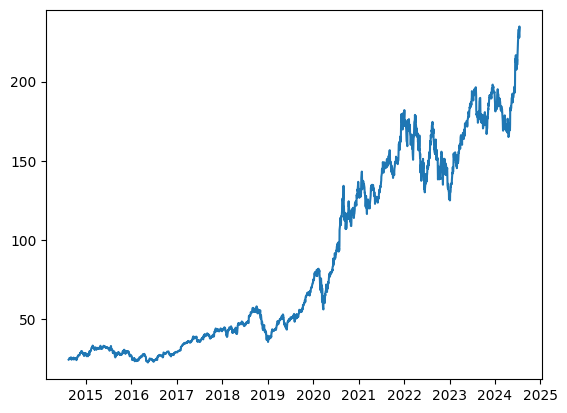

In [189]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [190]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2014-08-28,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.132500,24.790001,24.495001,24.375000
2014-08-29,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.132500,24.790001,24.495001
2014-09-02,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.132500,24.790001
2014-09-03,24.735001,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.132500
2014-09-04,24.530001,24.735001,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-11,227.570007,232.979996,228.679993,227.820007,226.339996,221.550003,220.270004,216.750000,210.619995,214.100006,213.250000
2024-07-12,230.539993,227.570007,232.979996,228.679993,227.820007,226.339996,221.550003,220.270004,216.750000,210.619995,214.100006
2024-07-15,234.399994,230.539993,227.570007,232.979996,228.679993,227.820007,226.339996,221.550003,220.270004,216.750000,210.619995


In [191]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 25.5625    ,  25.53249931,  25.22249985, ...,  24.79000092,
         24.49500084,  24.375     ],
       [ 25.625     ,  25.5625    ,  25.53249931, ...,  25.13249969,
         24.79000092,  24.49500084],
       [ 25.82500076,  25.625     ,  25.5625    , ...,  25.14249992,
         25.13249969,  24.79000092],
       ...,
       [234.3999939 , 230.53999329, 227.57000732, ..., 220.27000427,
        216.75      , 210.61999512],
       [234.82000732, 234.3999939 , 230.53999329, ..., 221.55000305,
        220.27000427, 216.75      ],
       [228.38999939, 234.82000732, 234.3999939 , ..., 226.33999634,
        221.55000305, 220.27000427]])

In [192]:
shifted_df_as_np.shape

(2487, 11)

In [193]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.97194147, -0.97222418, -0.97509618, ..., -0.97835634,
        -0.98080063, -0.98189037],
       [-0.9713525 , -0.97194147, -0.97216911, ..., -0.97499447,
        -0.97783528, -0.98067631],
       [-0.96946779, -0.9713525 , -0.97188583, ..., -0.97489631,
        -0.97439248, -0.97769176],
       ...,
       [ 0.996042  ,  0.95966722,  0.93550989, ...,  0.94041872,
         0.95175028,  0.90236984],
       [ 1.        ,  0.996042  ,  0.96355309, ...,  0.95298281,
         0.98713343,  0.96438775],
       [ 0.93940672,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [194]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2487, 10), (2487,))

In [195]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98189037, -0.98080063, -0.97835634, ..., -0.97338339,
        -0.97509618, -0.97222418],
       [-0.98067631, -0.97783528, -0.97499447, ..., -0.9749281 ,
        -0.97216911, -0.97194147],
       [-0.97769176, -0.97439248, -0.97489631, ..., -0.97198127,
        -0.97188583, -0.9713525 ],
       ...,
       [ 0.90236984,  0.95175028,  0.94041872, ...,  1.        ,
         0.93550989,  0.95966722],
       [ 0.96438775,  0.98713343,  0.95298281, ...,  0.94857303,
         0.96355309,  0.996042  ],
       [ 1.        ,  1.        ,  1.        , ...,  0.97680551,
         1.        ,  1.        ]])

In [196]:
split_index = int(len(X) * 0.8)

split_index

1989

In [197]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1989, 10), (498, 10), (1989,), (498,))

In [198]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1989, 10, 1), (498, 10, 1), (1989, 1), (498, 1))

In [199]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1989, 10, 1]),
 torch.Size([498, 10, 1]),
 torch.Size([1989, 1]),
 torch.Size([498, 1]))

In [200]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [201]:
train_dataset

In [202]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [203]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [204]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [205]:
train = []
val = []

In [206]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            train.append(avg_loss_across_batches)
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [207]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    val.append(avg_loss_across_batches)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [208]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.275

Val Loss: 0.696
***************************************************

Epoch: 2
Batch 100, Loss: 0.112

Val Loss: 0.531
***************************************************

Epoch: 3
Batch 100, Loss: 0.053

Val Loss: 0.276
***************************************************

Epoch: 4
Batch 100, Loss: 0.012

Val Loss: 0.146
***************************************************

Epoch: 5
Batch 100, Loss: 0.006

Val Loss: 0.110
***************************************************

Epoch: 6
Batch 100, Loss: 0.005

Val Loss: 0.090
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.076
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.062
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.050
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.039
********************************

In [209]:
print(train)
print(val)

[0.2751586925983429, 0.11218887478113175, 0.05339525164104998, 0.011801947033382021, 0.00596663013973739, 0.0045504453527973965, 0.003556871542241424, 0.00280676300462801, 0.002138483294402249, 0.001626893116044812]
[0.6964652491733432, 0.5310519835911691, 0.2756902831606567, 0.1460758898720087, 0.10997417130420217, 0.09037176666242885, 0.07576569754746743, 0.06191164822485007, 0.050256197007911396, 0.039083325153114856]


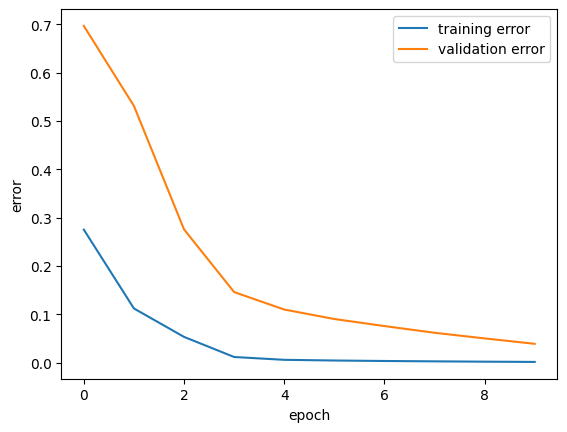

In [210]:
plt.plot(train, label="training error")
plt.plot(val, label="validation error")
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

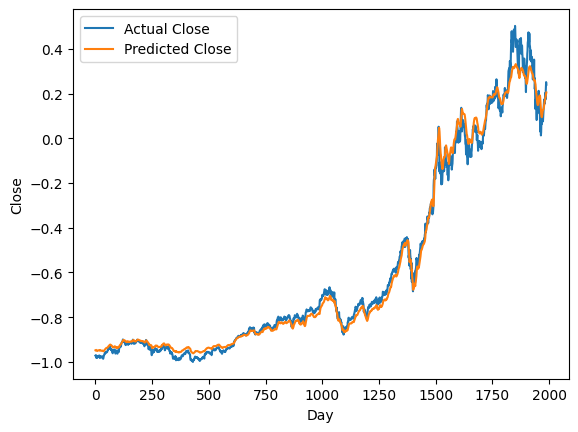

In [211]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [212]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 28.10745317,  28.15860422,  28.20833213, ..., 148.97381172,
       149.63226372, 150.41735995])

In [213]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 25.56250014,  25.62499842,  25.82499796, ..., 153.03999307,
       155.35000673, 154.08999698])

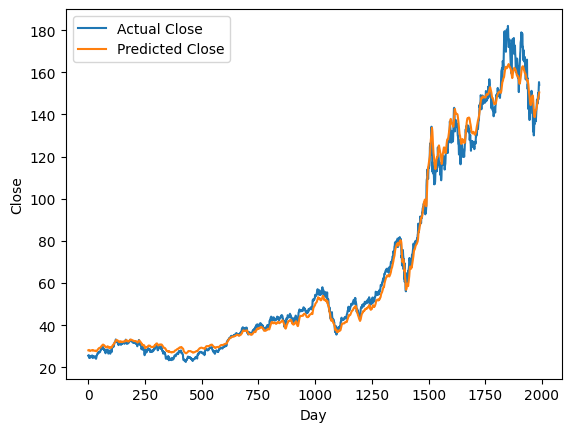

In [214]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [215]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([151.16167513, 151.67631025, 151.92526603, 152.24505973,
       152.79376815, 153.48834909, 154.39133879, 155.0261539 ,
       155.59415544, 156.4098177 , 157.09120133, 157.61838228,
       158.00070588, 158.28727385, 158.78487865, 159.13507076,
       159.68645785, 160.24197207, 160.64443478, 161.08950017,
       161.44882572, 161.56466669, 161.32658058, 160.99879829,
       160.71053203, 160.59607942, 160.01150771, 159.28107612,
       158.3887695 , 157.493819  , 156.74912748, 155.97316785,
       155.27228395, 154.73989903, 154.32062105, 154.47016214,
       154.76649922, 154.52355544, 154.26385964, 153.73516383,
       153.31467776, 153.29508894, 153.3313096 , 153.16711011,
       152.81878706, 152.32809559, 152.06763762, 151.79523471,
       151.05182718, 149.59380713, 148.21029355, 147.51856997,
       147.31246513, 147.21349319, 146.74844524, 146.07575229,
       145.35545193, 144.61990175, 144.44959696, 144.19127371,
       144.09919928, 144.3437528 , 144.70991736, 145.05

In [216]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([152.94999644, 151.60000587, 156.78999393, 157.35000529,
       162.50999342, 161.50999572, 160.00999601, 166.13000407,
       165.80999848, 165.35000586, 164.86999432, 164.91999736,
       169.2400064 , 168.49000496, 172.10000614, 173.19000364,
       173.02999768, 174.55000367, 174.1499951 , 171.52000432,
       167.57000708, 167.22999521, 167.52999768, 170.02999826,
       163.61999403, 161.38000551, 158.91000486, 157.22000243,
       157.96000705, 155.80999618, 154.52999913, 155.96000533,
       154.4600072 , 157.36999576, 163.4299913 , 153.83999597,
       155.30999733, 152.36999461, 150.69999687, 154.47999608,
       156.89999368, 153.72000099, 152.74000483, 150.42999275,
       150.77000462, 151.75999443, 149.83999569, 142.47999523,
       138.19999717, 142.44999688, 146.10000587, 146.39999411,
       145.42999318, 140.08999598, 140.41999838, 138.97999537,
       138.33999605, 142.99000512, 138.38000466, 142.41000329,
       143.75000021, 143.85999996, 143.38999946, 147.27

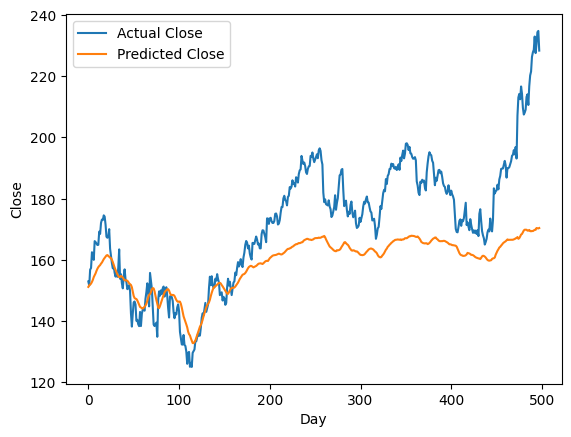

In [217]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [218]:
predicted_price = test_predictions[-1]

#r2 = r2_score(y_test, model(X_test).detach().numpy())
#print(model(X_test).detach().numpy())

In [219]:
def evaluate_model(model, X_test, y_test):
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the forward pass
    with torch.no_grad():
        predictions = model(X_test)

    # Detach the predictions tensor and convert to numpy
    predictions_np = predictions.detach().numpy()

    return mean_squared_error(y_test, predictions_np)

mse = evaluate_model(model, X_test, y_test)

In [220]:
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')

AAPL Stock Prices

Stock Price Now:  228.39
Predicted Stock Price:  170.41
Mean Squared Error on Test Data:  0.03
